# Transfer learning

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 16s 0us/step


## Example 1: feature extraction using VGG16 convolutional base, then training classifier

In [2]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './mini/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(train_features, train_labels,
    epochs=30,
    batch_size=20,
    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 633us/step - loss: 0.5921 - acc: 0.6815 - val_loss: 0.4361 - val_acc: 0.8370
Epoch 2/30
2000/2000 [==============================] - 1s 269us/step - loss: 0.4280 - acc: 0.8040 - val_loss: 0.3638 - val_acc: 0.8530
Epoch 3/30
2000/2000 [==============================] - 1s 268us/step - loss: 0.3508 - acc: 0.8585 - val_loss: 0.3400 - val_acc: 0.8600
Epoch 4/30
2000/2000 [==============================] - 1s 270us/step - loss: 0.3112 - acc: 0.8740 - val_loss: 0.3084 - val_acc: 0.8640
Epoch 5/30
2000/2000 [==============================] - 1s 268us/step - loss: 0.2789 - acc: 0.8935 - val_loss: 0.2810 - val_acc: 0.8940
Epoch 6/30
2000/2000 [==============================] - 1s 267us/step - loss: 0.2654 - acc: 0.8945 - val_loss

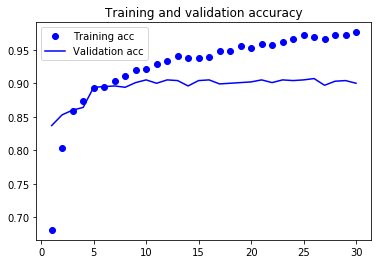

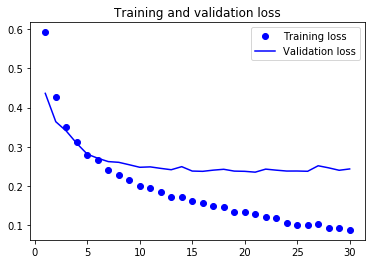

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Example 2: feature extraction with data augmentation

### Now we train the model using the VGG16 frozen convolutional base and custom classifier on top

In [14]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [16]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 4
This is the number of trainable weights after freezing the conv base: 4


In [20]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary')


model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=2e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 7s 71ms/step - loss: 0.3641 - acc: 0.8330 - val_loss: 0.2611 - val_acc: 0.8900
Epoch 2/30
100/100 [==============================] - 6s 64ms/step - loss: 0.3400 - acc: 0.8520 - val_loss: 0.3111 - val_acc: 0.8560
Epoch 3/30
100/100 [==============================] - 6s 63ms/step - loss: 0.3570 - acc: 0.8540 - val_loss: 0.2414 - val_acc: 0.9000
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 0.3227 - acc: 0.8480 - val_loss: 0.2780 - val_acc: 0.8860
Epoch 5/30
100/100 [==============================] - 6s 62ms/step - loss: 0.3317 - acc: 0.8570 - val_loss: 0.2360 - val_acc: 0.9120
Epoch 6/30
100/100 [==============================] - 6s 62ms/step - loss: 0.3342 - acc: 0.8460 - val_loss: 0.2620 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 6s 62ms/step - loss: 0.3233 - acc: 0.8640 - val_loss: 0.2554 - v

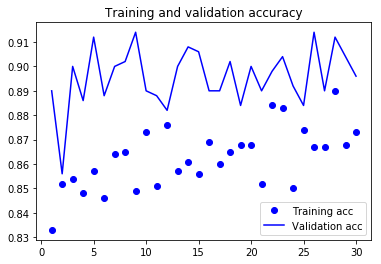

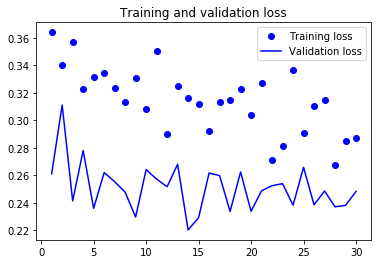

In [21]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Example 3: fine-tuning (re-train top VGG layers)

In [22]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
model.compile(loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-5),
    metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/30
100/100 [==============================] - 7s 71ms/step - loss: 0.3156 - acc: 0.8550 - val_loss: 0.2412 - val_acc: 0.9020
Epoch 2/30
100/100 [==============================] - 6s 64ms/step - loss: 0.2491 - acc: 0.8960 - val_loss: 0.2421 - val_acc: 0.9060
Epoch 3/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2730 - acc: 0.8760 - val_loss: 0.1933 - val_acc: 0.9220
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2742 - acc: 0.8730 - val_loss: 0.2487 - val_acc: 0.8920
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2218 - acc: 0.9030 - val_loss: 0.1668 - val_acc: 0.9340
Epoch 6/30
100/100 [==============================] - 6s 63ms/step - loss: 0.2286 - acc: 0.9080 - val_loss: 0.2192 - val_acc: 0.9200
Epoch 7/30
100/100 [==============================] - 6s 64ms/step - loss: 0.2028 - acc: 0.9190 - val_loss: 0.2530 - val_acc: 0.9120
Epoch 8/30
100/100 [==============================] - 6s 64ms/step - 

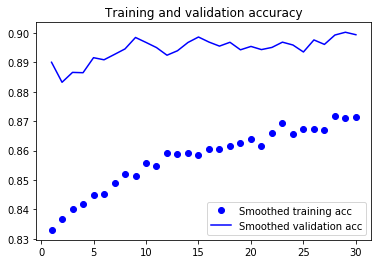

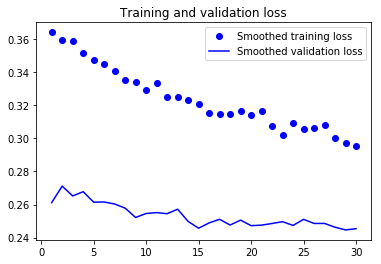

In [25]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [26]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9439999902248383
